In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
# from torch.utils.data import dataloader
from torchvision import transforms
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


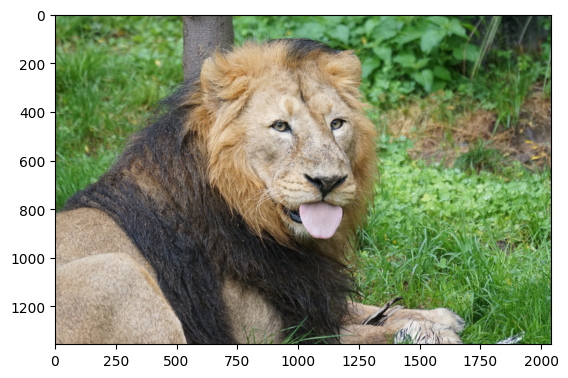

In [3]:
img_path = "DIV2K_valid_HR/0809.png"

img = Image.open(img_path)
plt.imshow(img)

In [4]:
img.size

(2040, 1356)

In [5]:
transform_funcs = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(512),
])

In [6]:
test_img = transform_funcs(img)

In [7]:
def tensor_img_show(tensor_img):
    numpy_img = transforms.ToPILImage()(tensor_img)
    plt.imshow(numpy_img)

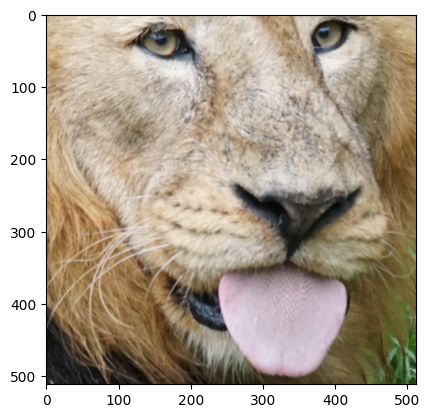

In [8]:
tensor_img_show(test_img)

In [13]:
coords = np.linspace(0,1,512, endpoint=False)
x_test=np.stack(np.meshgrid(coords,coords), -1)
test_data=[x_test, test_img.numpy()]
train_data=[x_test[::2,::2], test_img.numpy()[::2,::2]]

In [19]:
coords.size

512

In [21]:
x_test.shape

(512, 512, 2)

In [23]:
test_data[0].shape

(512, 512, 2)

In [17]:
train_data[0].shape

(256, 256, 2)

In [26]:
x_proj = (2.*np.pi*train_data[0])@ np.random.rand(256, 2).T

In [27]:
x_proj.shape

(256, 256, 256)

In [31]:
np.sin(x_proj).shape

(256, 256, 256)

In [34]:
np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1).shape

(256, 256, 512)

In [ ]:
def make_Gaussian_Vec(scale=10):
    gauss_vec = torch.randn(256)*scale
    return gauss_vec

class GaussianFourierFeaturesMapping(nn.Module):
    def __init__(self, scale=None):
        super(GaussianFourierFeaturesMapping, self).__init__()
        self.scale = scale

    def forward(self, x):
        output = self.input_mapping(x, scale=self.scale)
        return output
    
    def input_mapping(x, scale):
        if scale is None:
            return x
        else:
            B = make_Gaussian_Vec(scale)
            x_proj = (2*np.pi*x) @ B.T
            return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

In [ ]:
class ReconNet(nn.Module):
    def __init__(self, num_layers=4, mapping_size=256):
        super(ReconNet, self).__init__()
        self.dense_block = self.make_dense_block(num_layers=num_layers, num_channels=mapping_size)
        self.last_layer = nn.Linear(mapping_size, 3)
    
    def forward(self, x):
        x = self.dense_block(x)
        x = self.last_layer(x)
        output = torch.sigmoid(x)
        return output
    
    def make_dense_block(num_layers, num_channels):
        layers = []
        for i in range(num_layers-1):
            layers.append(nn.Linear(num_channels))
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)